# Multi-temporal parameter decomposition with RT1 and scipy optimize.

This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to obtain multiple dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.

> **NOTE:** to run this example you need the additional dependencies [matplotlib](https://matplotlib.org/) and [ipympl](https://matplotlib.org/ipympl/).


In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB, sig0 = False, True

num = 50  # Number of measurements
incs = 5  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = np.random.normal(45, 10, (num, incs)).clip(20, 70)         # Incidence angles
N = np.random.normal(0.1, 0.1, (num, 1)).clip(0.01, 0.25)        # NormBRDF values
tau = (1*np.sin(np.linspace(0, 2*np.pi, num))**2)[:,np.newaxis]  # Optical Depth values

sim_params = dict(tau=tau, omega=0.2, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4)  # Constant parameters (assumed to be known)

### Set start values and boundaries for the fit

In [3]:
start_vals = dict(tau=[0.3]*num, omega=0.2, N=[0.1] * num)
bnd_vals = dict(tau=[(0.01, 1.)]*num, omega=(0.01, 0.5), N=[(0.01, 0.5)] * num)

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc), p_0=0, geometry="mono")
R.update_params(**sim_params, **const_params)

tot = R.calc()[0]
tot += np.random.normal(0, noise_sigma, tot.shape)  # Add some random noise

15:19:09.015 INFO: Evaluating coefficients for interaction-term...
15:19:09.127 INFO: Coefficients extracted, it took 0.01361 sec.
D:\python_modules\RT1_new\src\rt1_model\_calc.py:1098: RuntimeWarning: invalid value encountered in add
  np.exp(-tau / mu) * np.log(mu / (1.0 - mu))


## Setup scipy optimize to fit RT1 model to the data

In [5]:
from scipy.linalg import block_diag

param_names = list(sim_params)

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(omega=x[0], tau=x[1:num+1][:,np.newaxis], N=x[num+1:][:, np.newaxis])

def fun(x, R):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **const_params)

    # Ravel output because scipy requires 1D arrays
    res = (R.calc()[0] - tot).ravel()
    return res

def jac(x, R):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **const_params)

    jac = np.array(R.jacobian(param_list=["omega", "tau", "N"]))

    # Reshape jacobian to fit scipy.optimize requirements
    rejac = jac.reshape(jac.shape[0], -1)

    usejac = np.full((rejac.shape[1], 2*num + 1), 0.0)
    usejac[:, 0] = rejac[0]
    usejac[:, 1:num+1] = block_diag(*jac[1]).T
    usejac[:, num+1:] = block_diag(*jac[2]).T

    return usejac

# Unpack start-values and boundaries as required by scipy optimize
x0 = [start_vals["omega"], *start_vals["tau"], *start_vals["N"]]
bounds = list(zip(*[bnd_vals["omega"], *bnd_vals["tau"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-8,
    gtol=1e-8,
    xtol=1e-5,
    verbose=2,
    kwargs=dict(R=R)
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params, **const_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4002e-01                                    3.05e-01    
       1              2         6.6407e-02      2.74e-01       1.74e+00       3.13e-02    
       2              3         3.5140e-02      3.13e-02       9.83e-01       3.05e-02    
       3              4         2.5054e-02      1.01e-02       3.84e-01       4.08e-02    
       4              5         2.3200e-02      1.85e-03       6.23e-02       4.03e-02    
       5              6         1.4103e-02      9.10e-03       3.34e-01       3.67e-02    
       6              7         1.2940e-02      1.16e-03       8.75e-02       3.40e-02    
       7              8         1.2491e-02      4.49e-04       3.77e-02       3.31e-02    
       8              9         1.2151e-02      3.40e-04       2.52e-02       3.26e-02    
       9             10         1.0879e-02      1.27e-03       9.15e-02       3.01e-02    

## Visualize Results
### Plot timeseries

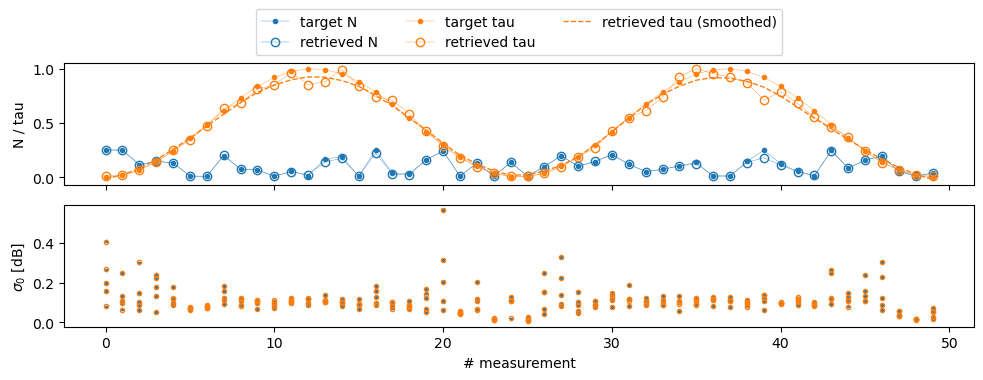

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)

ax.set_ylabel("N / tau")
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N", c="C0")
ax.plot(
    found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N", c="C0"
)

ax.plot(sim_params["tau"], marker=".", lw=0.25, label="target tau", c="C1")
ax.plot(
    found_params["tau"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved tau", c="C1"
)

ax.plot(
    savgol_filter(found_params["tau"].ravel(), 15, 3), lw=1, c="C1", ls="--", label="retrieved tau (smoothed)"
)


ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.5))
f.tight_layout()

### Initialize analyzer widget and overlay results

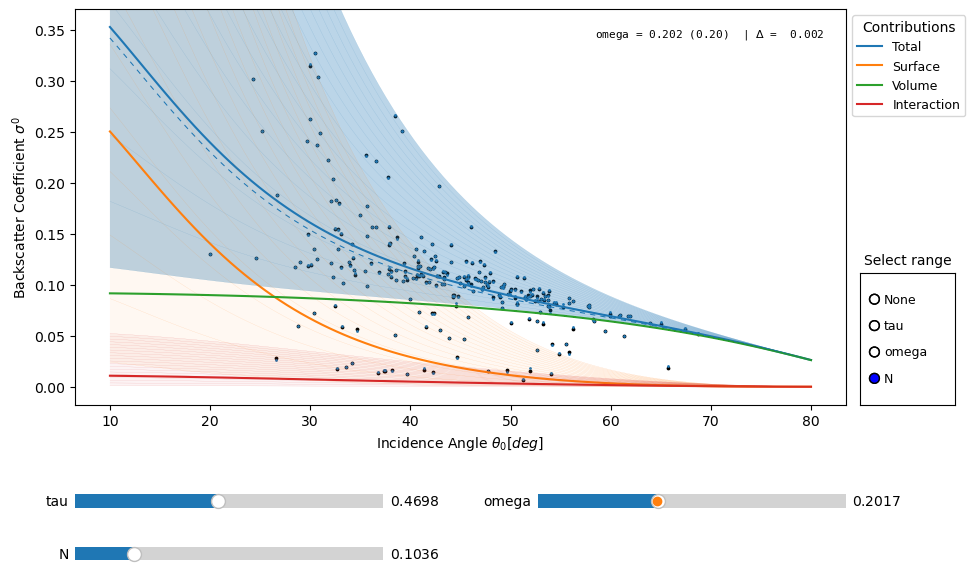

In [7]:
analyze_params = {key: (*np.mean(np.atleast_2d(bnd_vals[key]), axis=0), found_params[key].mean()) for key in param_names}

ana = R.analyze(param_dict=analyze_params, range_parameter="N")

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)